# Финальный спринт: «Прогнозирование оттока клиентов»

# Задача
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание услуг
Оператор предоставляет два основных типа услуг:

Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
Также доступны такие услуги:

Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
Выделенная линия технической поддержки (TechSupport);
Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

## Описание данных
Данные состоят из файлов, полученных из разных источников:

contract.csv — информация о договоре;
personal.csv — персональные данные клиента;
internet.csv — информация об интернет-услугах;
phone.csv — информация об услугах телефонии.
Во всех файлах столбец customerID содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# План работы
- Провести обзор и общую подготовку данных (проверить типы и содержимое, исправить данные при необходимости, провести работу над пропусками)
- Исследовать данные (посмотреть зависимости, вузализация данных, предварительные выводы)
- Окончательная подготовка данных для моделей (балансировка, исключение признаков, скалирование, OHE)
- Работа с моделями и подбор параметров (в т.ч. оптимизация для лучшего решения)
- Выбор итоговой модели и вывод

In [3]:
# Блок импорта
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Корреляция
import phik
from phik.report import plot_correlation_matrix
from phik import report

# Подготовка моделей
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

# Метрики
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# CatBoost
from catboost import CatBoostClassifier, Pool, cv

pd.options.mode.chained_assignment = None

In [4]:
RANDOM_STATE = 130323

# Обзор данных и их подготовка

## Обзор

Загрузим данные

In [5]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [6]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
4939,9975-SKRNR,2020-01-01,No,Month-to-month,No,Mailed check,18.90,18.9
4048,6762-QVYJO,2015-04-01,No,Two year,No,Mailed check,59.75,3624.35
3375,3642-BYHDO,2014-03-01,No,Two year,No,Bank transfer (automatic),19.90,1389.35
3246,8806-EAGWC,2019-09-01,2019-12-01 00:00:00,Month-to-month,No,Mailed check,55.15,159.15
5181,5727-MYATE,2014-02-01,No,Two year,Yes,Credit card (automatic),90.80,6397.6


In [7]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5467,6967-PEJLL,DSL,Yes,No,Yes,Yes,No,No
2800,7860-UXCRM,DSL,Yes,Yes,Yes,Yes,Yes,No
2112,5213-TWWJU,Fiber optic,No,No,Yes,Yes,No,Yes
4742,8757-TFHHJ,DSL,Yes,No,No,No,No,No
2190,1023-BQXZE,DSL,Yes,No,Yes,No,Yes,Yes


In [8]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
350,0513-RBGPE,Male,0,Yes,Yes
382,8204-YJCLA,Male,1,Yes,Yes
5575,1492-KGETH,Male,0,Yes,Yes
2871,7508-MYBOG,Male,0,Yes,No
3119,5307-DZCVC,Female,1,Yes,No


In [9]:
phone.sample(5)

,customerID,MultipleLines
4648,8020-BWHYL,No
6085,1272-ILHFG,No
6343,7203-OYKCT,Yes
6163,3005-NFMTA,Yes
5116,5143-WMWOG,No


Проверим, все ли данные у нас есть

In [10]:
contract.shape, internet.shape, personal.shape, phone.shape

((7043, 8), (5517, 8), (7043, 5), (6361, 2))

Нет смысла работать с признаками отдельно, соберём все данные вместе и посмотрим, что получится

In [11]:
df = contract.merge(personal, how='left', on='customerID').\
merge(internet, how='left', on='customerID').\
merge(phone, how='left', on='customerID')
df = df.set_index('customerID')
df.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7938-OUHIO,2019-07-01,2019-10-01 00:00:00,Month-to-month,Yes,Electronic check,98.70,293.65,Male,0,No,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,No
5027-YOCXN,2015-11-01,No,One year,No,Credit card (automatic),110.05,5686.4,Male,0,Yes,Yes,Fiber optic,Yes,Yes,No,Yes,Yes,Yes,Yes
5389-FFVKB,2017-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Credit card (automatic),80.30,2483.05,Male,1,Yes,No,Fiber optic,No,No,No,No,No,Yes,No
1399-OUPJN,2015-05-01,No,Two year,No,Bank transfer (automatic),19.75,1272.05,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
4572-DVCGN,2019-01-01,2019-11-01 00:00:00,Month-to-month,Yes,Bank transfer (automatic),80.25,846,Female,0,No,No,Fiber optic,No,No,No,No,No,Yes,No


Посмотрим базовую информацию

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

### Промежуточный вывод
Познакомились с намиши данными, визуально оценили качество данных.
Определились с максимальным количеством данных из датасета `contract`.

Предстроит заполнение пропусков, изменение типов итд...

## Подготовка данных

### Пропуски

Вероятнее всего, пропуски указывают на отсутствие предоставляемых услуг (поэтому мы можем безопасно пометить их как No). 

Единственная проблема заключается в том, что для поля `InternetService` необходимо указать тип подключения, поэтому мы должны рассмотреть возможные варианты.

In [13]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

Если данные распределены таким образом, то заполнение наиболее часто встречающимся значением (модой) не кажется правильным подходом, поэтому мы добавим еще одно значение в словарь, которое будет обозначать неопределенные данные - `Undefined`.

In [14]:
df['InternetService'] = df['InternetService'].fillna('Undefined')
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Undefined      1526
Name: InternetService, dtype: int64

В остальных полях отсутствие данных не вызывает вопросов, поэтому мы заполним пропущенные значения как `No`

In [15]:
null_columns = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]
df[null_columns] = df[null_columns].fillna('No')

Для единообразия переименуем колонку `gender`

In [16]:
df = df.rename(columns={'gender':'Gender'})

Изменение типов данных не имеет большого смысла, так как позже значения Yes-No будут преобразованы в числа.

Важно помнить, что в данной задаче значение No для EndDate соответствует 1 февраля 2020 года.

### Преобразование данных

Сохраним целевой признак до преобразования дат

In [17]:
df['Result'] = (df['EndDate'] != 'No').astype('int')

Преобразуем типы дат, чтобы получить нужную нам информацию

In [18]:
df.loc[(df['EndDate'] == 'No'), 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

Рассчитаем количество дней пользования услугами

In [19]:
df['UsingServiceDays'] = (df['EndDate'] - df['BeginDate']).dt.days
df['UsingServiceDays'] = df['UsingServiceDays'].astype('int')

Преобразуем TotalCharges во float, в процессе обнаружилась ошибка, посмотрим на данные

In [21]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df[df['TotalCharges'].isnull()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Result,UsingServiceDays
customerID,,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,...,DSL,Yes,No,Yes,Yes,Yes,No,No,0,0
3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,Male,0,No,...,Undefined,No,No,No,No,No,No,No,0,0
5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,...,Undefined,No,No,No,No,No,No,Yes,0,0
1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,...,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0,0
7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,...,Undefined,No,No,No,No,No,No,No,0,0
3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,...,Undefined,No,No,No,No,No,No,Yes,0,0
2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,...,Undefined,No,No,No,No,No,No,No,0,0
2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,...,Undefined,No,No,No,No,No,No,No,0,0


Это явно клиенты, которые пользовались услугами менее месяца и еще не успели оплатить ничего. Поэтому мы присвоим им общие отчисления, равные нулю.

In [22]:
df['TotalCharges'] = df['TotalCharges'].fillna(0)

Удалим BeginDate и EndDate, дабы избежать утечек

In [23]:
del df['BeginDate'], df['EndDate']

Преобразуем признаки пола

In [24]:
df['Gender'] = (df['Gender'] == 'Male').astype('int')

Посмотрим остальные словарные значения, чтобы понимать, что к ним применять

In [25]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [26]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Undefined      1526
Name: InternetService, dtype: int64

In [27]:
df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Так как признаки не масштабируются и количество уникальных значений внутри каждого признака не слишком велико, мы будем использовать One-Hot Encoding (OHE).

Мы подготовим наборы признаков для One-Hot Encoding преобразования и масштабирования, а также выделим целевой признак от остальных. Преобразования будут выполнены после проведения исследовательского анализа данных.

In [28]:
ohe_names = ['PaymentMethod', 'InternetService', 'Type']
numeric_names = ["TotalCharges", "MonthlyCharges", "UsingServiceDays"]
target_name = 'Result'
features_names = list(df.columns)
features_names.remove(target_name)
categories = [x for x in features_names if x not in numeric_names]

len(features_names), len(categories)

(18, 15)

Посмотрим, что у нас в итоге получилось

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   Gender            7043 non-null   int32  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null 

## Промежуточный вывод

- Были обработаны пропуски, создана новая, ценная нецелевые метрика `UsingServiceDays`.
- Изненены типы данных для временных признаков
- Выделен целевой признак, предопределены нецелевые категориальные и численные признаки
- Вручную преобразованы все значения вида Yes-No в числа
- Удалены возможные утечки целевого признака

# Исследовательский анализ данных

Проверим баланс классов

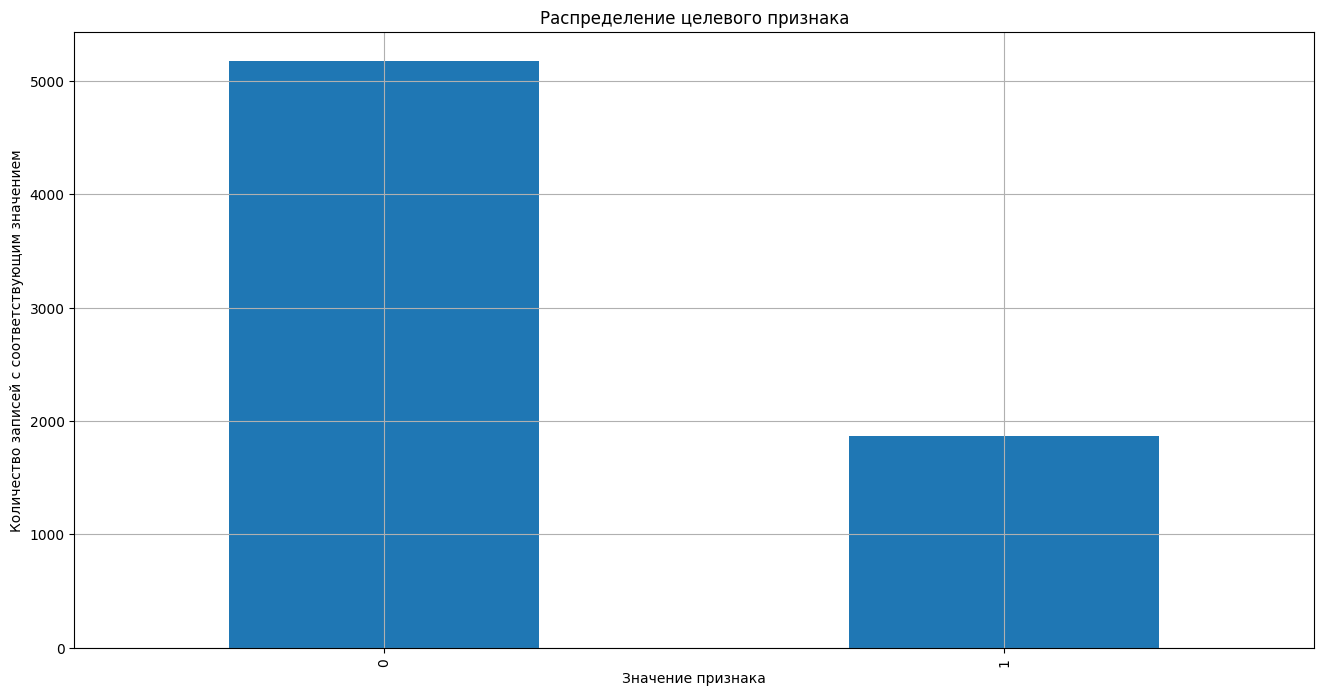

In [30]:
df_target = df[target_name]
fig, ax = plt.subplots(1)
ax.set_title('Распределение целевого признака')
ax.set_xlabel('Значение признака')
ax.set_ylabel('Количество записей с соответствующим значением')
df_target.value_counts().plot(kind='bar', figsize=(16,8), ax=ax, grid = True);

В данных наблюдается явный дисбаланс классов в пользу значения, которое нам нужно предсказать. Из-за этого, downsampling не кажется оптимальным решением.

Сначала мы попробуем upsampling. Если это не приведет к достижению необходимой метрики, мы рассмотрим балансировку классов на уровне моделей. И только если ничего не поможет, мы рассмотрим вариант downsampling.

Посмотрим распределение нецелевых признаков

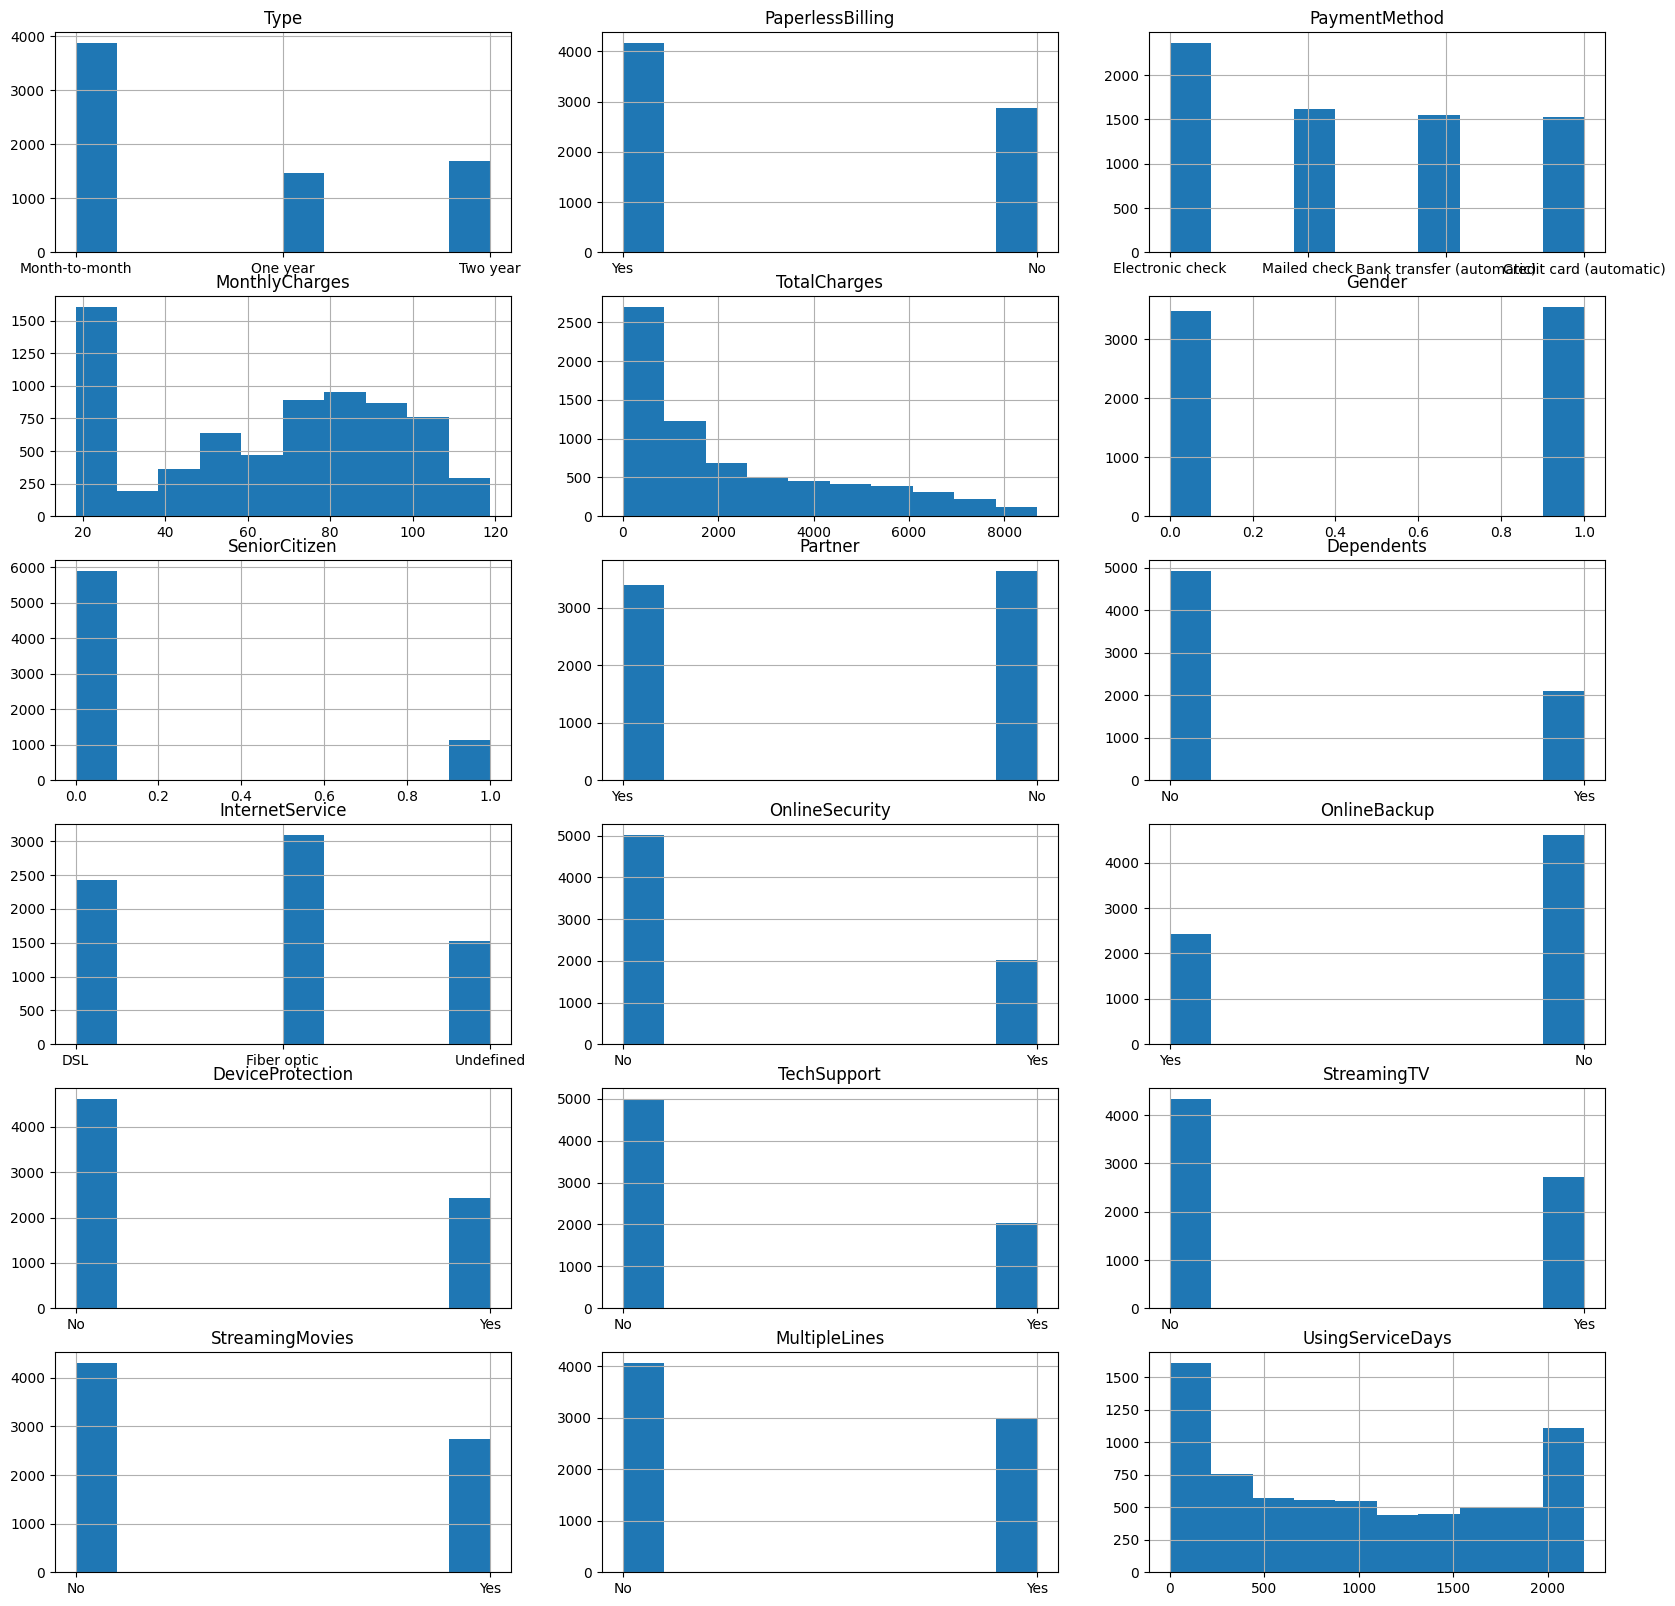

In [31]:
ncols = 3
nrows = math.ceil(len(features_names) / ncols)

plt.figure(figsize=(20, 20))

counter = 0
for feature in features_names:
    counter += 1
    plt.subplot(nrows, ncols, counter)
    plt.hist(df[feature])
    plt.title(feature)
    plt.grid()

## Промежуточный вывод
Видно, что дополнительные услуги не пользуются популярностью, а те, кто их выбирают, часто выбирают одни и те же услуги. 

Также стоит обратить внимание на распределения общих расходов и длительности пользования услугами, потому что клиенты, выбирающие более дорогие тарифы, скорее всего, остаются на более длительный срок. 

Однако, несмотря на дисбаланс классов, распределения остальных признаков достаточно равномерны. В связи с этим, для улучшения модели имеет смысл выделить наиболее значимые признаки.

Посмотрим на распределение относительно нашего целевого признака

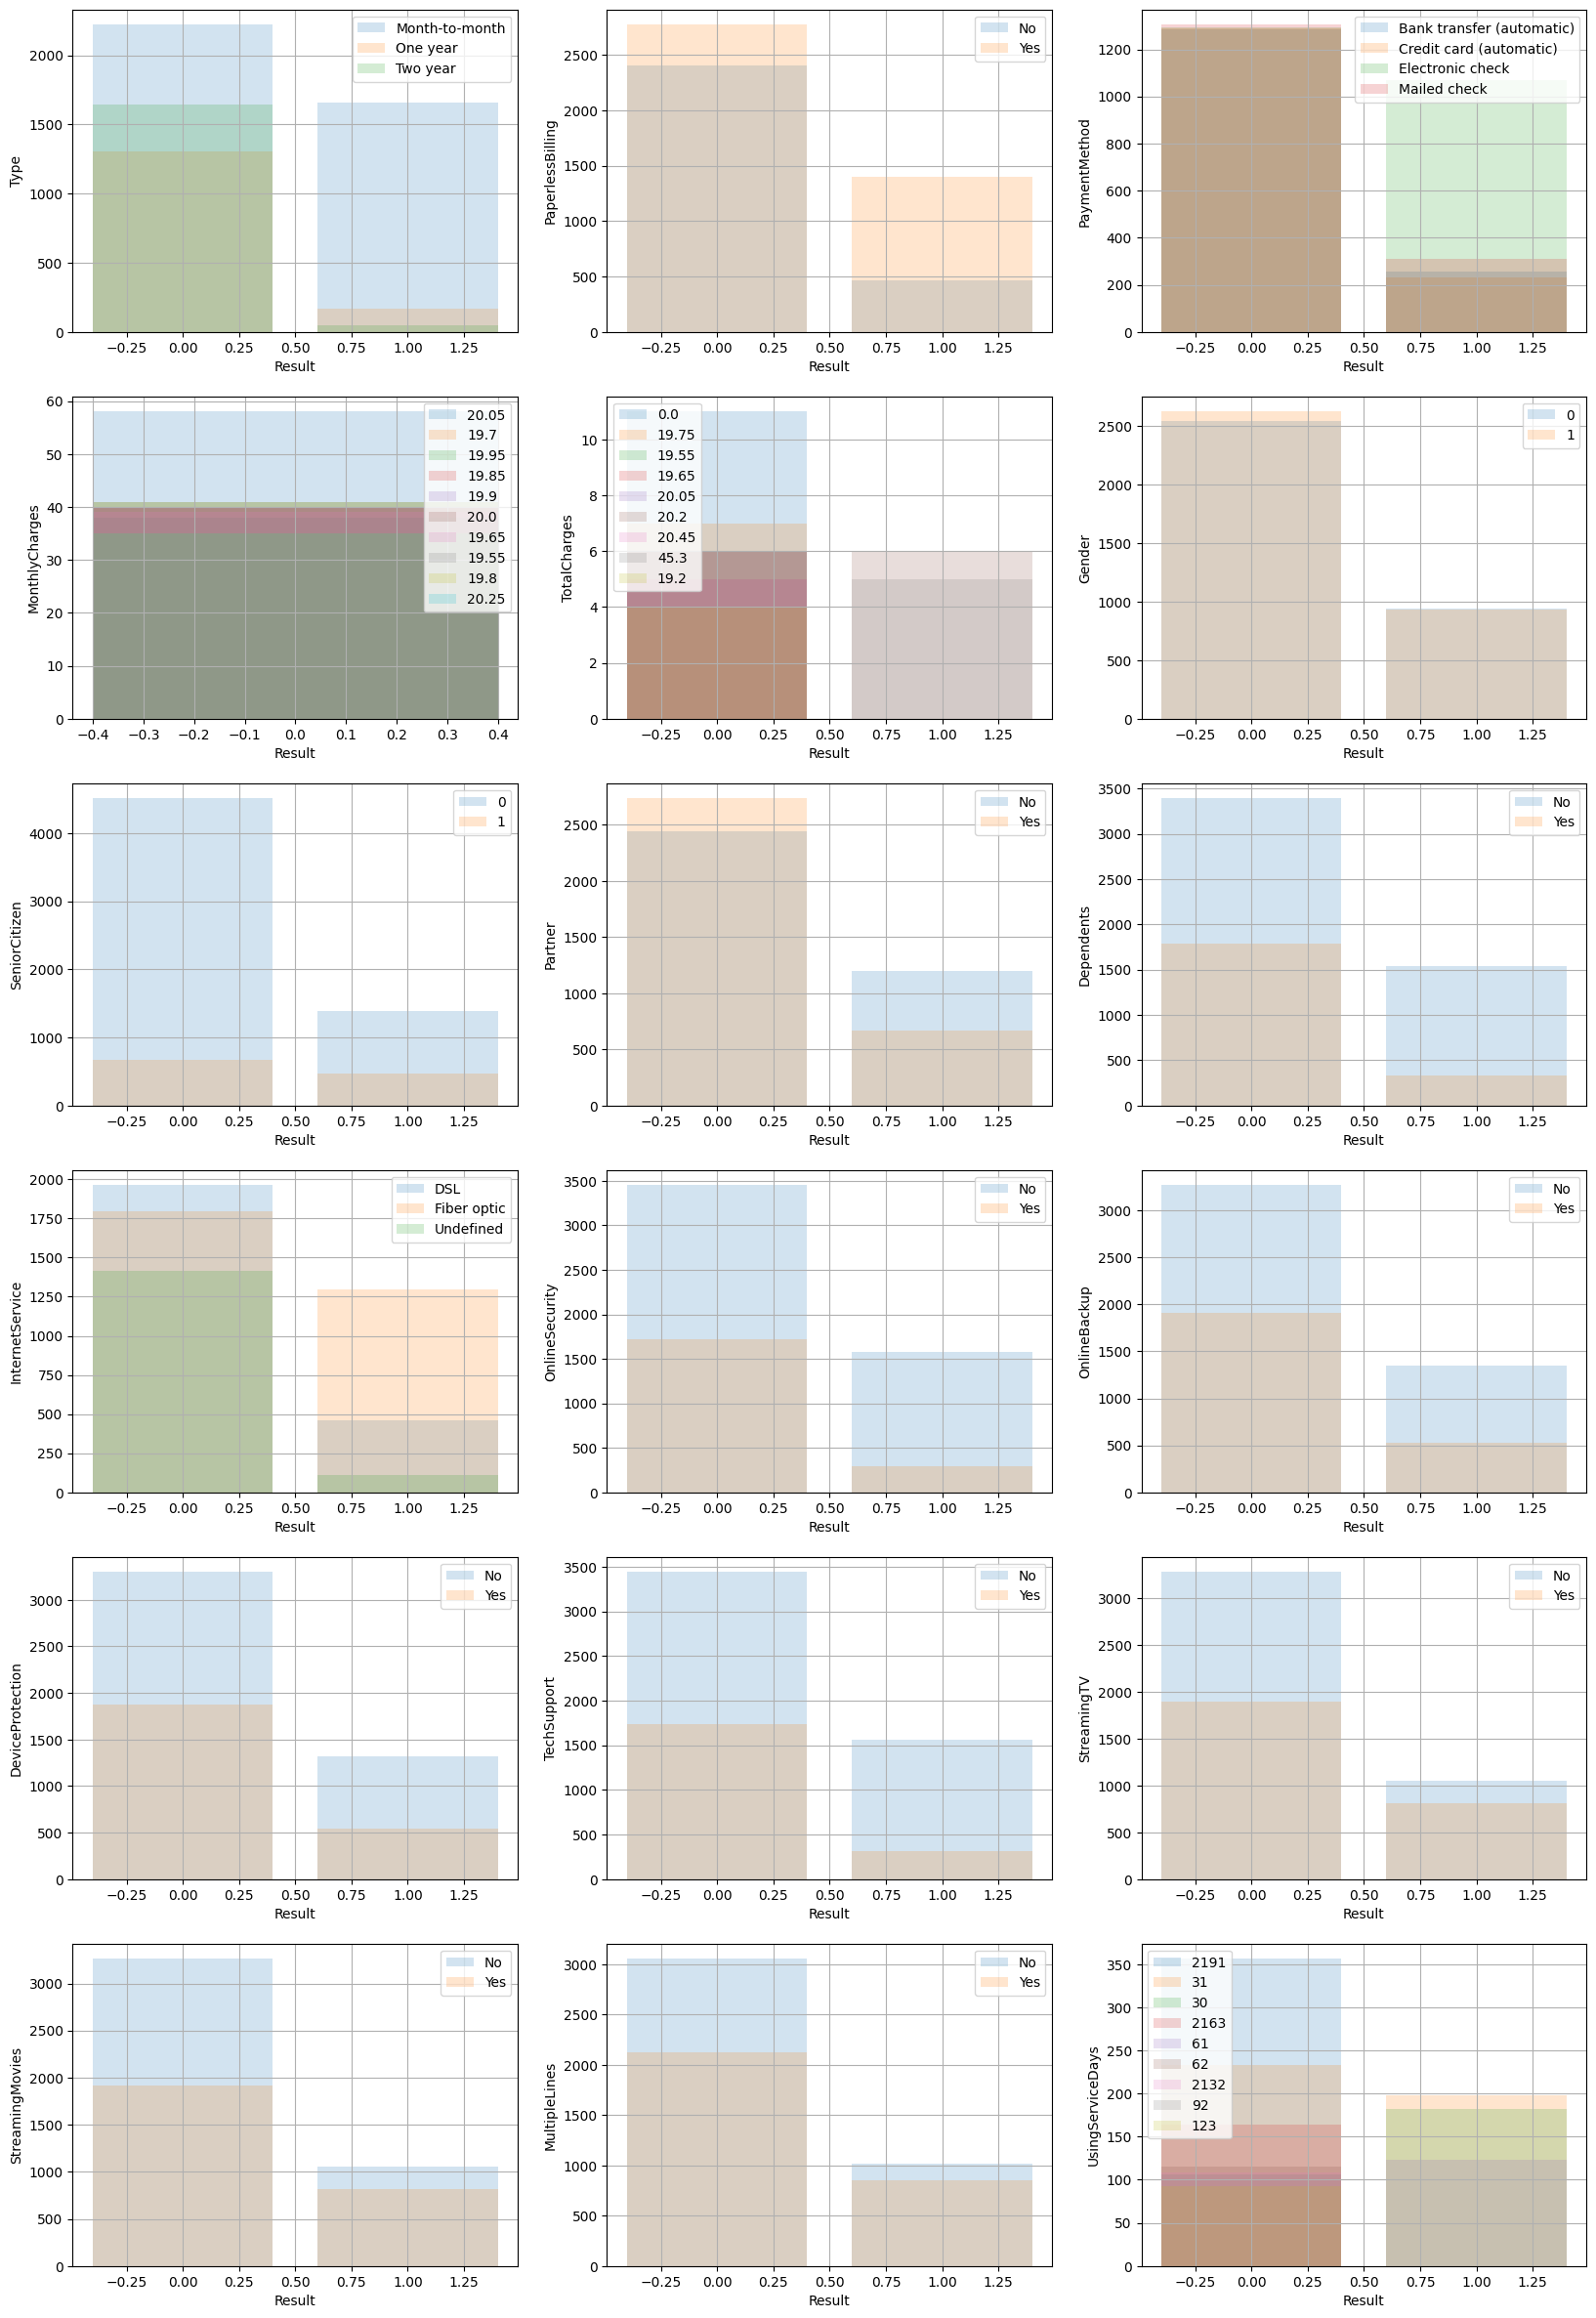

In [32]:

plt.figure(figsize=(20, 30))

counter = 0
for feature in features_names:
    counter += 1
    feature_values = set(df[feature])
    
    if len(feature_values) > 10:
        feature_values = df[feature].value_counts().index[:10]
    
    ax = plt.subplot(nrows, ncols, counter)

    df_tmp = df.groupby([feature, target_name])[target_name].count().nlargest(10)
    df_tmp = df_tmp.unstack()

    for column in df_tmp.T.columns:
        ax.bar(df_tmp.T.index, df_tmp.T[column], alpha=0.2, label = column)

    plt.xlabel(target_name)
    plt.ylabel(feature)
    plt.legend()
    plt.grid()

## Промежуточный вывод
Интересно, что у клиентов, выбирающих ежемесячную оплату, доля отказов примерно одинаковая, в то время как у клиентов, выбирающих оплату за год или два, доля отказов минимальная. Это может быть связано с нехваткой данных, и если бы у нас были данные за более длительный период, количество отказов могло бы измениться.

По графику количества дней использования видно, что наибольшее количество отказов связано с использованием услуг до двух месяцев, при этом с увеличением времени пользования количество отказов снижается.

Дополнительные услуги оказывают незначительное влияние на целевой показатель, так как доля отказов примерно одинакова как у клиентов, которые пользуются этими услугами, так и у клиентов, которые не пользуются ими.

Интересно, что клиенты, не пользующиеся интернетом, имеют наименьшую долю отказов, а на втором месте по количеству отказов находятся клиенты с подключением DSL, что может быть связано с тем, что в некоторых районах DSL является единственной альтернативой. А клиенты, использующие оптический интернет, отказываются от услуг проще всего.

Посмотрим выбросы и диаграмму размаха

In [33]:
df.describe()

,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Result,UsingServiceDays
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.504756,0.162147,0.265370,985.996166
std,30.090047,2266.794470,0.500013,0.368612,0.441561,747.587844
min,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,0.000000,0.000000,273.000000
50%,70.350000,1394.550000,1.000000,0.000000,0.000000,883.000000
75%,89.850000,3786.600000,1.000000,0.000000,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,1.000000,1.000000,2191.000000


Посмотрим диаграммы размаха

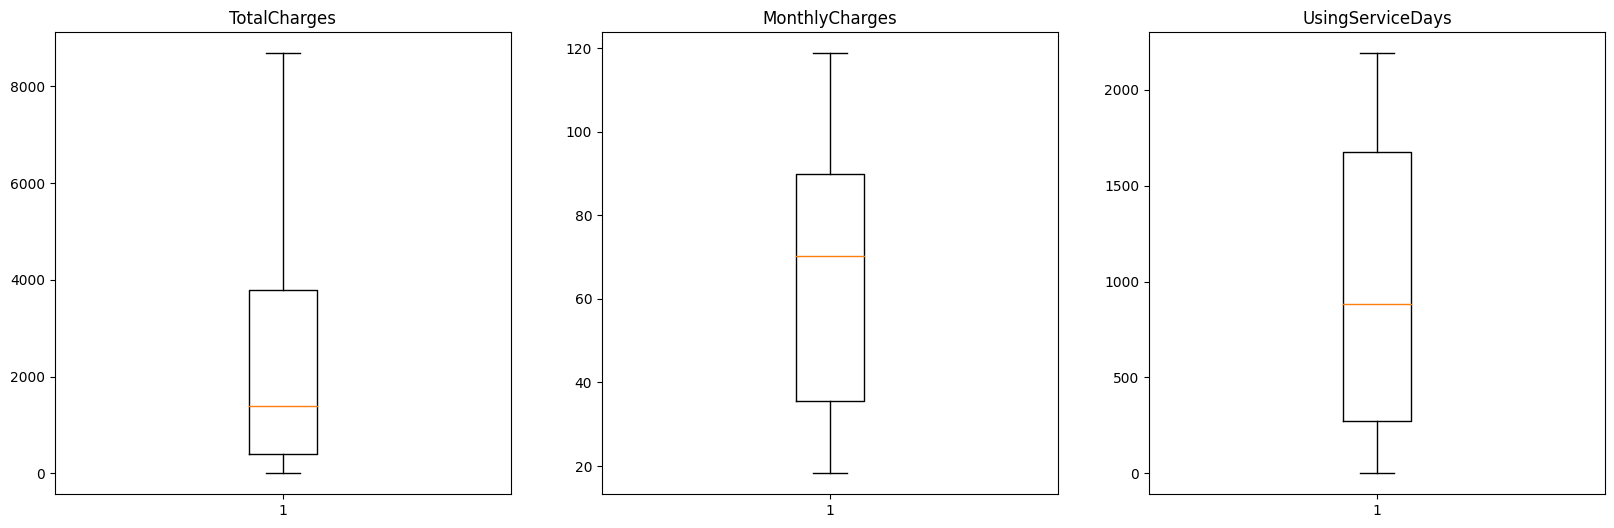

In [34]:
plt.figure(figsize=(20, 6))

counter = 0
numeric_len = len(numeric_names)
for feature in numeric_names:
    counter += 1
    plt.subplot(1, numeric_len, counter)
    plt.boxplot(df[feature])
    plt.title(feature)

## Вывод по исследованию данных
Обнадеживает в этом проекте факт, что данные распределены довольно равномерно и не нуждаются в значительной обработке.

Были проанализированы графики:
- Распределения целевого признака
- Диаграммы размаха численных признаков
- Распределение нецелевых признаков
- Также распределение этих признаков относительного целевого

Далее будут рассмотрены вопросы корреляции признаков, подготовки данных для работы с моделями машинного обучения.

# Подготовка данных для моделей

Оценим значимость признаков, посмотрим матрицу корреляции

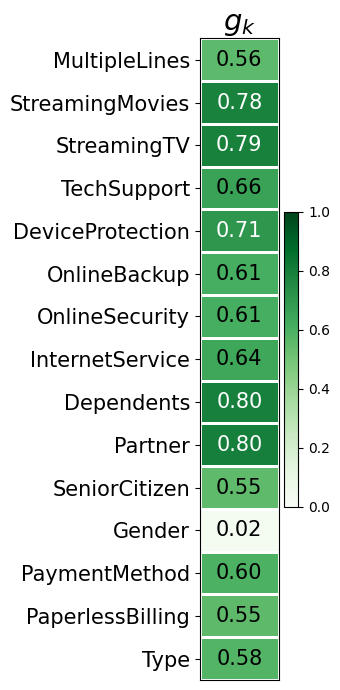

In [36]:
global_correlation, global_labels = df[categories].global_phik(interval_cols = ['MonthlyCharges', 'TotalCharges', 'UsingServiceDays'])

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,7),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5);
plt.tight_layout();

In [37]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Gender', 'SeniorCitizen', 'Result', 'UsingServiceDays']


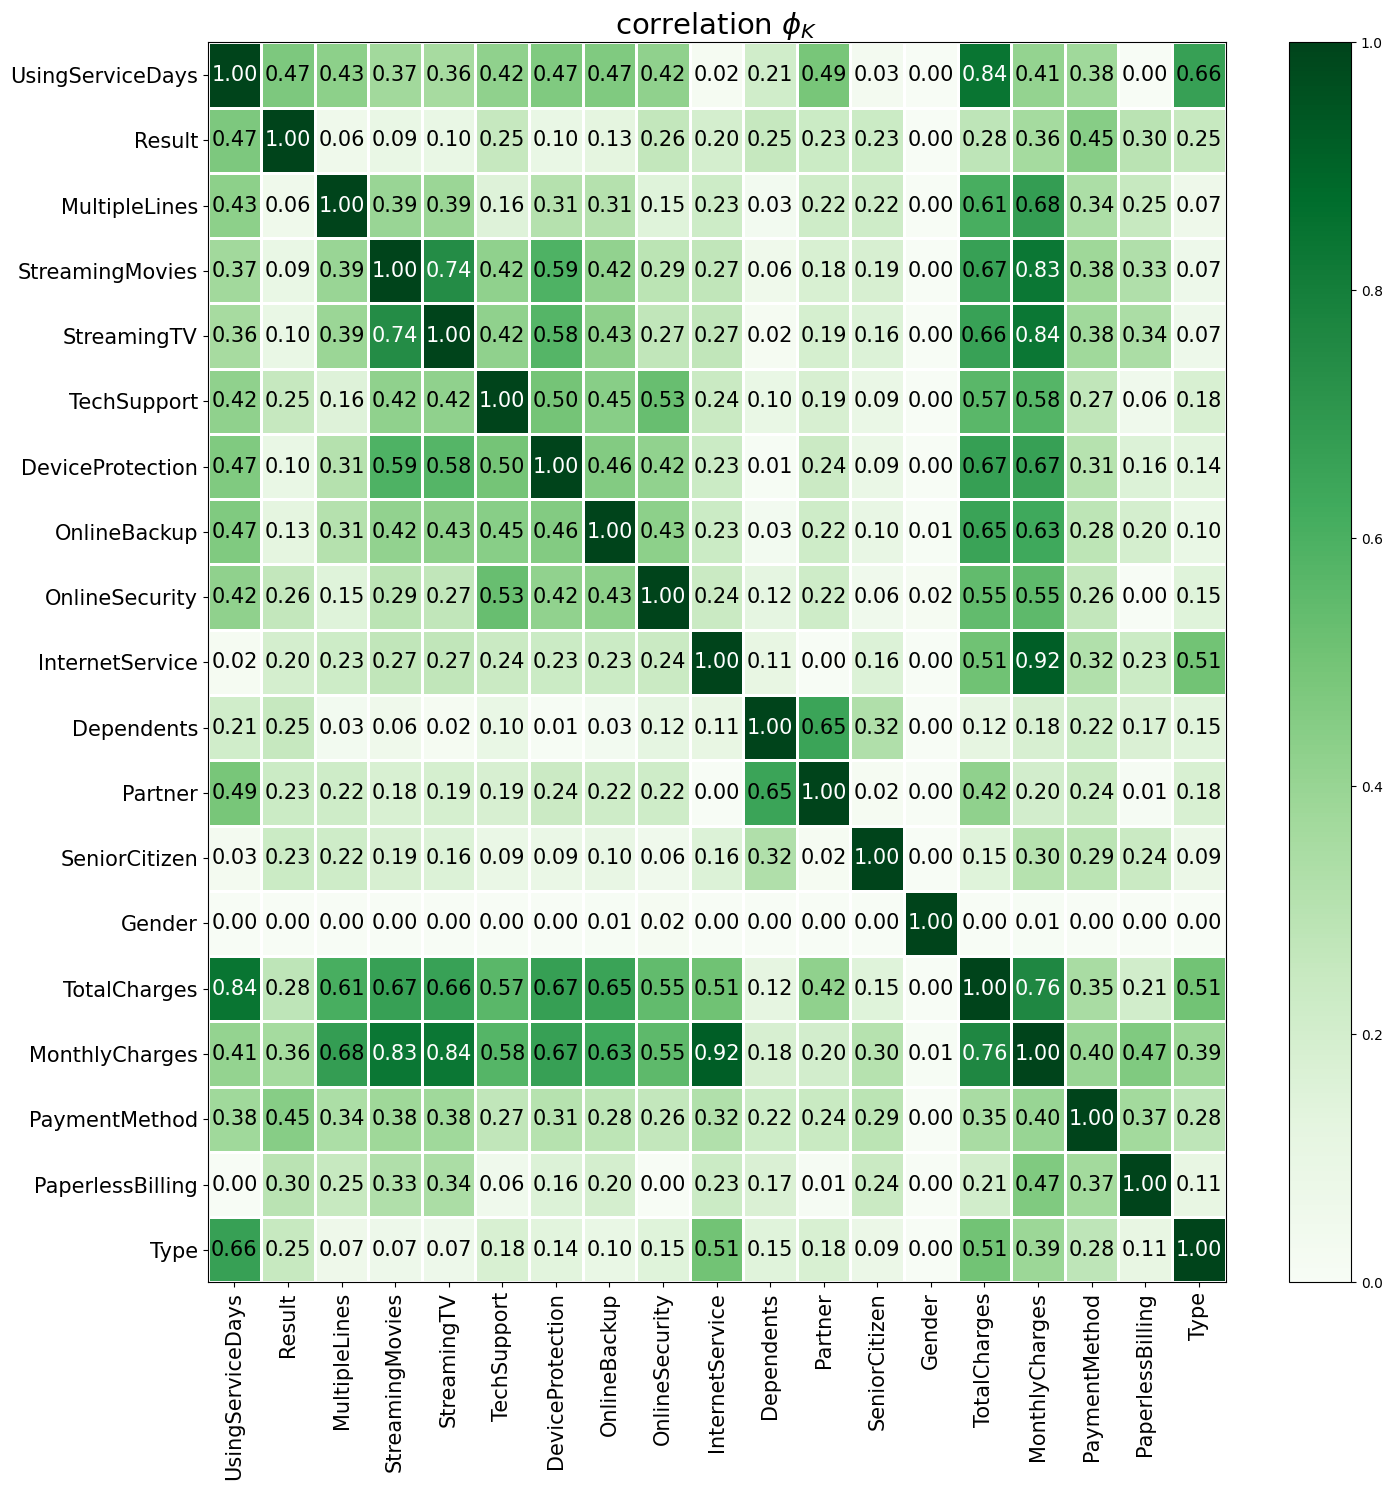

In [38]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 15))
plt.tight_layout()

Наиболее значимыми признаками являются количество дней использования и общая сумма платежей. При этом, размер ежемесячных платежей имеет отрицательную корреляцию с целевым показателем.

Аномальных корреляций среди нецелевых признаков не обнаружено, всё поддается простому логическому обьяснению.

Воспользуемся методом get_feature_importance у CatBoost, чтобы оценить значение признаков. Для начала разабьем датасет на трейн и тест, рассчитаем коэффиценты

In [39]:
df_features = df[features_names]
df_target = df[target_name]

features_train, features_test, target_train, target_test = train_test_split(df_features, df_target, test_size=0.25, random_state=RANDOM_STATE)

train_pool = Pool(data=features_train, label=target_train, cat_features=categories, feature_names=features_names)
v_counts = target_train.value_counts()
scale_pos_weight = v_counts[0] / v_counts[1]

scale_pos_weight

2.7863799283154123

In [40]:
catboost = CatBoostClassifier(verbose=0, task_type="GPU", devices='0:1', random_seed=RANDOM_STATE, thread_count=-1, scale_pos_weight=scale_pos_weight)
catboost.fit(train_pool)

Получим значимые признаки

In [41]:
features_and_score = list(zip(catboost.feature_names_, catboost.get_feature_importance()))
df_score = pd.DataFrame(features_and_score)
df_score.sort_values(by=1, ascending=False)

,0,1
17,UsingServiceDays,69.993240
0,Type,7.514561
3,MonthlyCharges,6.590964
4,TotalCharges,6.224100
9,InternetService,2.196364
2,PaymentMethod,1.565948
1,PaperlessBilling,1.370348
15,StreamingMovies,1.101685
13,TechSupport,0.726557
14,StreamingTV,0.571832


Общими выводами после анализа является то, что некоторые признаки не оказывают существенного влияния на итоговый результат. Поэтому уменьшение размерности набора признаков должно быть безопасным решением. В качестве эксперимента можно оставить только те признаки, которые имеют скоринг больше 1.

In [42]:
df_score.columns = ['feature_name', 'score']
features_choosen = list(df_score.query('score > 0.3')['feature_name'])
features_choosen

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'SeniorCitizen',
 'InternetService',
 'OnlineSecurity',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'UsingServiceDays']

In [43]:
features_train_linear = features_train[features_choosen]
features_test_linear = features_test[features_choosen] 

In [44]:
features_train = features_train[features_choosen]
features_test = features_test[features_choosen] 

In [46]:
ohe_names = ['PaymentMethod', 'InternetService', 'Type']
numeric_names = ["TotalCharges", "MonthlyCharges", "UsingServiceDays"]
target_name = 'Result'
features_names = list(df.columns)
features_names.remove(target_name)
categories = [x for x in features_names if x not in numeric_names and x in features_choosen]

len(features_names), len(categories)

(18, 10)

In [47]:
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'error')
ohe.fit(features_train[categories])
new_categories = ohe.get_feature_names(categories)

In [48]:
features_train_ohe = pd.DataFrame(ohe.transform(features_train[categories]).toarray(),
                                               columns = new_categories, index = features_train.index)
features_train_ohe = features_train_ohe.join(features_train[numeric_names])
features_test_ohe = pd.DataFrame(ohe.transform(features_test[categories]).toarray(),
                                               columns = new_categories, index = features_test.index)
features_test_ohe = features_test_ohe.join(features_test[numeric_names])

In [49]:
features_train_linear_ohe = pd.DataFrame(ohe.transform(features_train_linear[categories]).toarray(),
                                               columns = new_categories, index = features_train_linear.index)
features_train_linear_ohe = features_train_linear_ohe.join(features_train_linear[numeric_names])
features_test_linear_ohe = pd.DataFrame(ohe.transform(features_test_linear[categories]).toarray(),
                                               columns = new_categories, index = features_test_linear.index)
features_test_linear_ohe = features_test_linear_ohe.join(features_test_linear[numeric_names])

In [ ]:
features_train_ohe = features_train_ohe.round().astype(int)

In [ ]:
features_train_ohe.head().T

Проведем скалирование числовых признаков для линейной модели

In [50]:
scaler = StandardScaler()
scaler.fit(features_train_linear_ohe[numeric_names])

features_train_linear_ohe[numeric_names] = scaler.transform(features_train_linear_ohe[numeric_names])
features_test_linear_ohe[numeric_names] = scaler.transform(features_test_linear_ohe[numeric_names])

features_train_linear_ohe[numeric_names].sample(5, random_state=RANDOM_STATE)

,TotalCharges,MonthlyCharges,UsingServiceDays
customerID,,,
3005-TYFRD,1.495071,1.288909,0.921311
9513-DXHDA,-0.031655,0.563249,-0.221697
7762-ONLJY,-0.965162,-1.486451,-1.075608
4355-HBJHH,1.326162,0.497129,1.408495
4648-YPBTM,0.737724,0.305383,0.838329


## Вывод по подготовке данных для моделей
Были предприняты следующие шаги подготовки данных для работы с моделями машинного обучения:
- Первостепенно был решен вопрос важности признаков, рассмотрена тепловая карта и в отдельности корреляция с целевым признаком. Выявлены существенные признаки, влияющие на формирования целевого признака
- Данные были разделены на тестовую и тренеровочные выборки
- Категориальные признаки были закодированы с помощью 'OneHotEncoder'
- Численные признаки скалировались для линейной модели

# Обучение моделей

## Логистическая регрессия

In [51]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
model = LogisticRegression(solver='newton-cg', penalty='l2', class_weight = 'balanced')
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train_linear_ohe, target_train)
grid.best_params_

{'C': 10}

In [52]:
grid.best_score_

0.8451074432208856

## Случайный лес

In [53]:
%%time

param_grid = {
    'max_depth': [2, 10, 20, 30, 40],
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(2, 11, 2),
    'n_estimators': range(50, 101, 10)
}

model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')

grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train_ohe, target_train)
grid.best_params_

CPU times: total: 2min 51s
Wall time: 9min 9s


{'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 100}

In [54]:
grid.best_score_

0.855092481865017

## Дерево решений

In [55]:
%%time

param_grid = {
    "criterion":["gini", "entropy"],
    "max_depth": (2, 41, 2),
    "min_samples_split": range(2, 21, 2),
    "min_samples_leaf": range(2, 11, 2)
}

model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train_ohe, target_train)
grid.best_params_

CPU times: total: 5.38 s
Wall time: 11.7 s


{'criterion': 'entropy',
 'max_depth': 41,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [56]:
grid.best_score_

0.8122322089898175

## CatBoost

In [57]:
%%time

param_grid = {
    'iterations':[100, 1000],
    'learning_rate': [0.1, 0.3],
    'depth': range(6, 11, 2), 
    'l2_leaf_reg': range(3, 10, 2),
    'border_count':[128], # рекомендованное значение для GPU
}
# Закоментировал потому что ушло два часа на подбор параметров
model = CatBoostClassifier(loss_function='Logloss', auto_class_weights = 'Balanced', silent=True, eval_metric='AUC', task_type="GPU", devices='0:1', random_seed=RANDOM_STATE, thread_count=-1)
grid = GridSearchCV(model, param_grid,  cv=5, scoring='roc_auc')
grid.fit(features_train_ohe, target_train)
grid.best_params_

CPU times: total: 26min 56s
Wall time: 1h 47min 55s


{'border_count': 128,
 'depth': 10,
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'learning_rate': 0.1}

{'border_count': 128,
 'depth': 8,
 'iterations': 1000,
 'l2_leaf_reg': 7,
 'learning_rate': 0.1}

In [58]:
grid.best_score_

0.9068419289416056

## Вывод по обучению моделей
Были обучены и проверены по целевой метрике auc четыре модели машинного обучения.

Для всех моделей производился поиск наилучших гиперпараметров.

Лучший показатель предсказуемо подаказала модель градиентного бустинга, ожидание того стоило.

# Тест лучшей модели

In [59]:
def make_roc_curve(target_test, predicted_test):
    fpr, tpr, thresholds = roc_curve(target_test, predicted_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [67]:
model = CatBoostClassifier(loss_function='Logloss', auto_class_weights = 'Balanced', depth=10, l2_leaf_reg=3, eval_metric='AUC', iterations=1000, learning_rate=0.1, task_type="GPU", devices='0:1', random_seed=RANDOM_STATE, thread_count=-1, border_count=128, verbose=0)
model.fit(X = features_train_ohe, y = target_train)

In [68]:
predicted_test = model.predict_proba(features_test_ohe)[:,1]
roc_auc_score(target_test, predicted_test)

0.9254275963136722

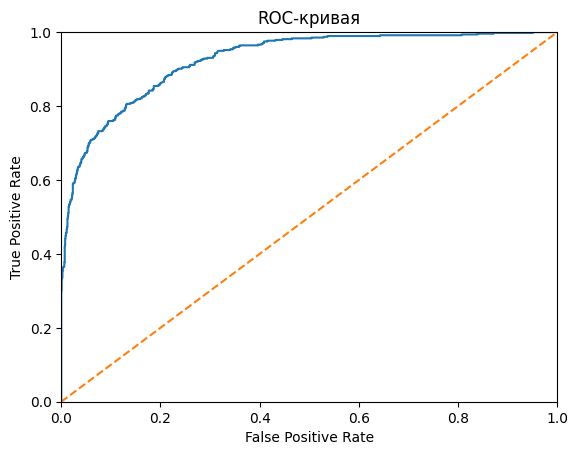

In [69]:
make_roc_curve(target_test, predicted_test)

## Проверка на адекватность

In [ ]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(features_train_ohe, target_train)
predicted = dummy_clf.predict_proba(features_test_ohe)[:, 1]
roc_auc_score(target_test, predicted)

0.5

## Вывод по тесту CatBoost
Модель сумела заметно превысить ожидаемый порог целевой метрики, показав результат 0.925

Также модель проверена на адекватность.

# Вывод

Мы собрали исходные данные, исправили пропуски и ошибки, а также добавили информацию о количестве дней использования услугами.

В ходе исследования мы обнаружили, что доля отказов при оплате помесячно примерно равна, а при оплате за год или два минимальна. Кроме того, мы установили, что отказы связаны с использованием услуг менее двух месяцев и что компания может предложить стимулы для удержания клиентов в течение трех и более месяцев.

Мы также выяснили, что суммарные затраты клиента влияют на вероятность оттока, поэтому важно удерживать клиентов с самого начала. Дополнительные услуги оказывают малое влияние на вероятность оттока, но они могут повлиять на суммарные затраты, поэтому следует принимать их во внимание.

Интересно, что клиенты, не пользующиеся интернетом, имеют меньшую вероятность отказа, а DSL-пользователи имеют высокую вероятность отказа, что может быть связано с отсутствием альтернативных вариантов подключения.

Мы подготовили данные для моделей, используя наиболее значимые признаки. Мы применили масштабирование для числовых признаков, OneHotEncoder для категориальных признаков и сбалансировали целевой признак при обучении моделей.


Итогом проекта стала настроенная модель градиентного бустинга CatBoost c гиперпараметрами:\
'border_count': 128,\
'depth': 10,\
'l2_leaf_reg': 3,\
'iterations': 1000,\
'learning_rate': 0.1 обученная на GPU.\
Данная модель показала показатель целевой метрики в 0.925, что отвечает условиям выполнения проекта.

Также стоит отметить, что наша модель была проверена и успешно прошла проверку на адекватность.

# Отчет

Операции проводимые с данными в предобработке:
- Заполнение пропусков в признаке 'InternetService' значением 'Undefined'.
- Заполнение пропусков в 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
- 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines' значением 'No'.
- Переименование признака 'gender' -> 'Gender'.
- Преобразование целевого признака 'Rusult' в int64.
- Создание нового признака 'UsingServiceDays' путем вычетания из даты окончания обслуживания/даты выгрузки даты начала обслуживания. Последующая трансформация признака в тип int64.
- Преобразуем TotalCharges во float, c заполнением пропусков нулями.
- Удаление BeginDate и EndDate во избежании утечек

Операции с данными перед обучением моделей:
- Проверка глобальной корреляции признаков
- Разделение данных на обучающую и тестовую выборки `в соотношении 75/25`
- Проверка значимости признаком с помощью catboost.get_feature_importance c последующим отбором
- Копирование выборок для отдельного обучения и поиска гиперпараметров линейных алгоритмов машинного обучения
- OneHotEncoding категориальных признаков, оставшихся после выделения значимых
- Скалирование числовых признаков для линейной модели

Итоговый список признаков - ['Type','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','SeniorCitizen','InternetService','OnlineSecurity','TechSupport','StreamingTV','StreamingMovies','MultipleLines','UsingServiceDays'].

Целевой признак - `Result`

Ещё раз отдельно выделю размер обучающей и тестовой выборки: 75% - обучающая, 25% - тестовая. RANDOM_STATE = 130323

Итоговая модель CatBoostClassifier со следующими гиперпараметрами: loss_function='Logloss', auto_class_weights = 'Balanced', depth=10, l2_leaf_reg=3, eval_metric='AUC', iterations=1000, learning_rate=0.1, task_type="GPU", devices='0:1', random_seed=RANDOM_STATE, thread_count=-1, border_count=128, verbose=0.


Существенных расхождений с первоначальным планом работы не было. Ключевое отличие заключается в разграничении методов подготовки признаков для линейной модели и для всех остальных.

Особых трудностей работа не вызвала.\
Ключевыми я считаю этап предобработки данных и этап финальной подготовки данных для обучения моделей. Два данных этапа потребовали наибольшее количество трудозатрат.\
Могу также отметить, что самым долгим оказался процесс нахождения лучших гиперпараметров для представленных в работе моделей. CatBoost искал свои параметры порядка двух часов, обучаясь на GPU.